In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

In [0]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

In [0]:
# !unzip UCI\ HAR\ Dataset.zip

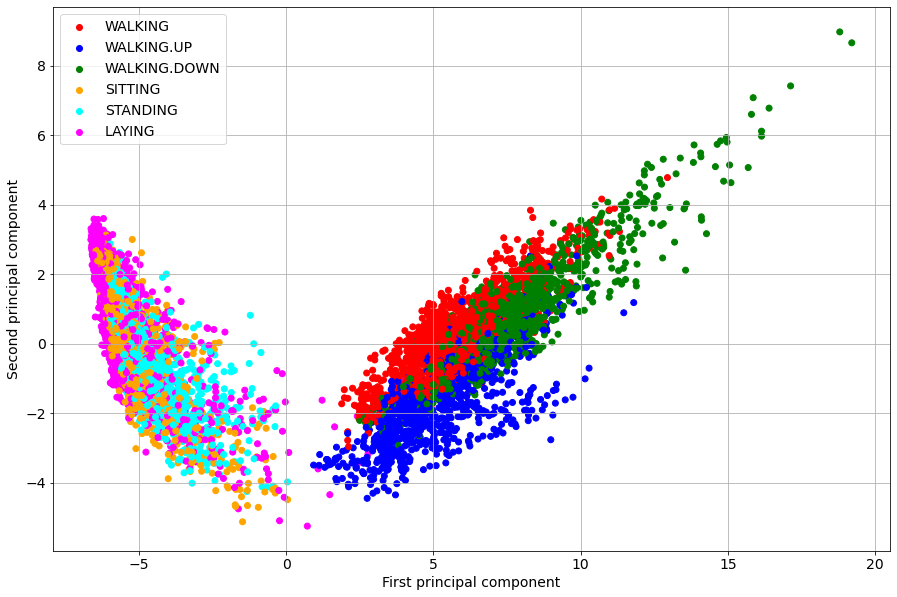

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
X_train = X_train.reshape(X_train.shape[0], 1, 32, 36)
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
y_train = y_train.reshape(-1)
Y_train = np_utils.to_categorical(y_train, 6)

In [0]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(1,32,36), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
%%time
model.fit(X_train, Y_train, epochs=100, validation_split=0.1, batch_size=16,shuffle=True)

Epoch 1/100
414/414 [==============================] - 1s 3ms/step - loss: 0.8556 - accuracy: 0.6245 - val_loss: 0.5038 - val_accuracy: 0.7609
Epoch 2/100
414/414 [==============================] - 1s 3ms/step - loss: 0.4371 - accuracy: 0.8281 - val_loss: 0.2712 - val_accuracy: 0.8886
Epoch 3/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2941 - accuracy: 0.8900 - val_loss: 0.2842 - val_accuracy: 0.8519
Epoch 4/100
414/414 [==============================] - 1s 3ms/step - loss: 0.2190 - accuracy: 0.9197 - val_loss: 0.2142 - val_accuracy: 0.8886
Epoch 5/100
414/414 [==============================] - 1s 3ms/step - loss: 0.1787 - accuracy: 0.9312 - val_loss: 0.1775 - val_accuracy: 0.9144
Epoch 6/100
414/414 [==============================] - 1s 3ms/step - loss: 0.1660 - accuracy: 0.9356 - val_loss: 0.2303 - val_accuracy: 0.9171
Epoch 7/100
414/414 [==============================] - 1s 3ms/step - loss: 0.1638 - accuracy: 0.9395 - val_loss: 0.1792 - val_accuracy: 0.9076

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 30, 34)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 15, 34)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 15, 34)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 13, 32)        9824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0

In [0]:
X_test = X_test.reshape(X_test.shape[0], 1, 32, 36)
X_test = X_test.astype('float32')
X_test /= np.amax(X_test)

In [0]:
predictions= model.predict(X_test)

In [0]:
y_pred = [np.argmax(x) for x in predictions]

In [0]:
y_test = y_test.reshape(-1)

In [17]:
(y_pred == y_test).mean()

0.9324737020699015

In [0]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.99      0.93      0.96       471
           2       0.88      1.00      0.94       420
           3       0.92      0.80      0.86       491
           4       0.85      0.93      0.89       532
           5       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947

